In [6]:
from time import sleep

import os
import argparse
from pathlib import Path
import yaml

try: 
    import ogb
except:
    os.system("pip install ogb")

try: 
    import tensorboard
except:
    os.system("pip install tensorboard")

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch_geometric
from torch import Tensor
from torch_geometric.loader import DataLoader

from torch.utils.tensorboard import SummaryWriter

import os

print(os.getcwd())
print(os.listdir())
print(os.listdir('..'))

from gnn_models import GCN_Graph_Classification, GCN, GCN_arxiv, SAGE_products, GCN_products
from train_func import test, train, Lhop_Block_matrix_train
from utils import label_dirichlet_partition, parition_non_iid, get_in_comm_indexes, get_in_comm_indexes_BDS_GCN, increment_dir, setdiff1d
from data_process import generate_data, load_data

/Users/yuhangya/Desktop/research/FedHGT/torch-distributed-test/mnmp/ray_fed
['FedGCN.ipynb', 'fed_training_gpu.py', 'Untitled.ipynb', 'Visualize_Distribution.ipynb', 'fedgcn_gpu.py', 'docker_gpu', 'README.md', 'gnn_models.py', 'experiments.py', 'config_gpu.yaml', 'data_process.py', 'utils.py', 'ogbn-arxiv_comm_accuracy_partial.pdf', 'docker_image_cpu', '.ipynb_checkpoints', 'fed_training.py', 'train_func.py', 'data', 'config_cpu.yaml']
['ray_fed', '.DS_Store', 'ray']


In [7]:
    parser = argparse.ArgumentParser()
    parser.add_argument('-d', '--dataset', default='ogbn-arxiv', type=str)
    
    parser.add_argument('-f', '--fedtype', default='fedgcn', type=str)
    
    parser.add_argument('-c', '--global_rounds',default=100, type=int)
    parser.add_argument('-i', '--local_step',default=3, type=int)
    parser.add_argument('-lr', '--learning_rate', default=0.5, type=float)
    
    parser.add_argument('-n', '--n_trainer', default=5, type=int)
    parser.add_argument('-nl', '--num_layers', default=2, type=int)
    parser.add_argument('-nhop', '--num_hops', default=2, type=int)
    parser.add_argument('-g', '--gpu', action='store_true') #if -g, use gpu
    parser.add_argument('-iid_b', '--iid_beta', default=10000, type=float)
    #parser.add_argument('-iid_p', '--iid_p', default=-1, type=float)
    
    parser.add_argument('-l', '--logdir', default='./runs', type=str)

    
    parser.add_argument('-r', '--repeat_time', default=10, type=int)
    args = parser.parse_args()
    print(args)

Namespace(dataset='ogbn-arxiv', fedtype='/Users/yuhangya/Library/Jupyter/runtime/kernel-963e1e53-5774-4a92-a29b-448973471e34.json', global_rounds=100, local_step=3, learning_rate=0.5, n_trainer=5, num_layers=2, num_hops=2, gpu=False, iid_beta=10000, logdir='./runs', repeat_time=10)


In [ ]:
args.n_trainer = 10


In [8]:
np.random.seed(42)
torch.manual_seed(42)
    
#load data to cpu
if args.dataset == 'simulate':
        number_of_nodes=200
        class_num=3
        link_inclass_prob=10/number_of_nodes
        link_outclass_prob=link_inclass_prob/20
        features, adj, labels, idx_train, idx_val, idx_test = generate_data(number_of_nodes,  class_num, link_inclass_prob, link_outclass_prob)               
else:
        features, adj, labels, idx_train, idx_val, idx_test = load_data(args.dataset)
        class_num = labels.max().item() + 1

in_feat = features.shape[1]
if args.dataset in ['simulate', 'cora', 'citeseer', 'pubmed', "reddit"]:
        args_hidden = 16
else:
        args_hidden = 256

row, col, edge_attr = adj.coo()
edge_index = torch.stack([row, col], dim=0)

Downloaded 0.08 GB: 100%|█████████████████████████████████████████████████████████████████████████| 81/81 [00:40<00:00,  1.98it/s]
Processing...


Extracting dataset/arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Converting graphs into PyG objects...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2511.56it/s]

Saving...



Done!


In [60]:
        args.iid_beta = 10000
        split_data_indexes = label_dirichlet_partition(labels, len(labels), class_num, args.n_trainer, beta = args.iid_beta)
        
        node_dict = dict()

        for i in range(len(split_data_indexes)):
            for j in split_data_indexes[i]:
                node_dict[j] = i
        
        one_hop_count = 0
        two_hop_count = 0
        BDS_one_local_update = 0
        for i in range(len(split_data_indexes)):
                neighbor1 = torch_geometric.utils.k_hop_subgraph(current_index,1,edge_index)[0]
                
                current_index = split_data_indexes[i]
                for node in current_index:
                    communicate_client = set()
                    #print(node, adj[node].nonzero())
                    
                    for neighbor in adj[int(node)].coo()[1]:
                        communicate_client.add(node_dict[int(neighbor)])
                
                    one_hop_count += len(communicate_client)
                    two_hop_count += len(communicate_client)
                
                two_hop_count += (len(neighbor1) - len(current_index))
                BDS_one_local_update += (len(neighbor1) - len(current_index))
        print(one_hop_count, two_hop_count, BDS_one_local_update)

867812 1639580 771768


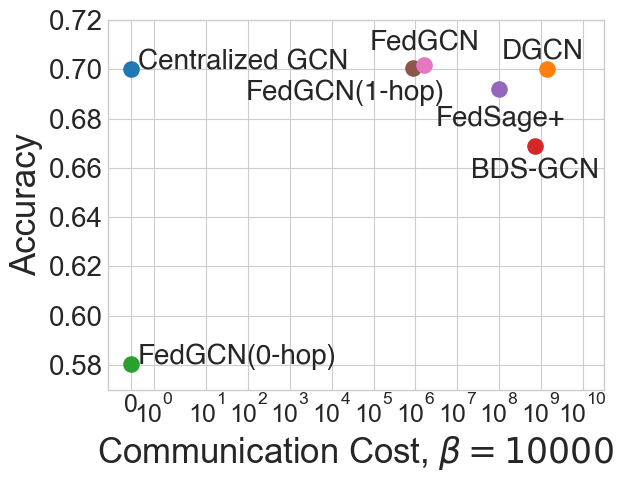

In [167]:
#beta=10000
one_hop_count = 867812
two_hop_count = 1639580
BDS_one_local_update = 771768
L = 3
local_steps = 3
bds_sample_rate = 0.5
global_round = 200

iid_total_bds = bds_one * L * global_round * local_steps * bds_sample_rate #times convergence time

iid_total_dgcn = bds_one * L * global_round * local_steps

iid_total_fedsage = len(labels) * global_round * local_steps

plt.style.use('seaborn-whitegrid')
x = [0, iid_total_dgcn, 0, iid_total_bds, iid_total_fedsage, one_hop_count, two_hop_count]

y = [0.7, 0.7, 0.5804, 0.6688,0.6918, 0.7004, 0.7017]

n = ["Centralized GCN", "DGCN", "FedGCN(0-hop)", "BDS-GCN", "FedSage+", "FedGCN(1-hop)", "FedGCN"]

fig, ax = plt.subplots()

ax.scatter(x[0], y[0], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[5], y[5], s=120)
ax.scatter(x[6], y[6], s=120)



hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
    
    #change location of annotation
    #if readers find better way to change it, please let me know
    if '0-hop' in txt:
        ax.annotate(txt, (x[i] + 0.3, y[i]), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i] * 0.0001, y[i] - 0.013), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i] * 0.05, y[i] + 0.006 ), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] * 0.03, y[i] - 0.013), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i]+0.3, y[i]), fontsize=20, **hfont)
    elif 'FedSage+' in txt:
        ax.annotate(txt, (x[i] * 0.03, y[i] - 0.015), fontsize=20, **hfont)
    elif 'DGCN' in txt:
        ax.annotate(txt, (x[i] * 0.08, y[i] + 0.004), fontsize=20, **hfont)

    
    
        
plt.ylim(0.57,0.72)

#ax.set_xscale('log')

ax.set_xscale('symlog')

#ticks = [0, 10**4,10**5,10**6,10**7,10**8,10**9,10**10]  # Specify the desired tick positions
#ax.set_xticks(ticks)

plt.xlim(-0.99, 10**10.5)



plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, $\\beta=10000$', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')

fig = plt.gcf()
#fig.set_size_inches((8.5, 11), forward=False)

fig.savefig("ogbn-arxiv_comm_accuracy_beta_10000.pdf", format='pdf', bbox_inches = "tight")

In [62]:
        args.iid_beta = 100
        split_data_indexes = label_dirichlet_partition(labels, len(labels), class_num, args.n_trainer, beta = args.iid_beta)
        
        node_dict = dict()

        for i in range(len(split_data_indexes)):
            for j in split_data_indexes[i]:
                node_dict[j] = i
        
        one_hop_count = 0
        two_hop_count = 0
        BDS_one_local_update = 0
        for i in range(len(split_data_indexes)):
                neighbor1 = torch_geometric.utils.k_hop_subgraph(current_index,1,edge_index)[0]
                
                current_index = split_data_indexes[i]
                for node in current_index:
                    communicate_client = set()
                    #print(node, adj[node].nonzero())
                    
                    for neighbor in adj[int(node)].coo()[1]:
                        communicate_client.add(node_dict[int(neighbor)])
                
                    one_hop_count += len(communicate_client)
                    two_hop_count += len(communicate_client)
                
                two_hop_count += (len(neighbor1) - len(current_index))
                BDS_one_local_update += (len(neighbor1) - len(current_index))
        print(one_hop_count, two_hop_count, BDS_one_local_update)

866201 1643567 777366


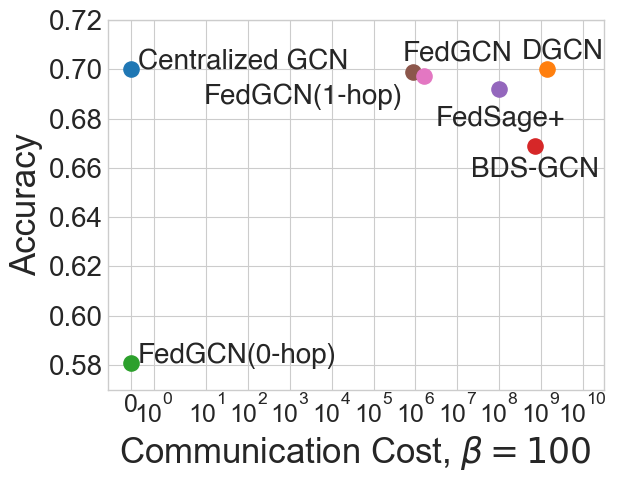

In [173]:
one_hop_count = 866201
two_hop_count = 1643567
BDS_one_local_update = 777366
L = 3
local_steps = 3
bds_sample_rate = 0.5
global_round = 200

iid_total_bds = bds_one * L * global_round * local_steps * bds_sample_rate #times convergence time

iid_total_dgcn = bds_one * L * global_round * local_steps

iid_total_fedsage = len(labels) * global_round * local_steps

plt.style.use('seaborn-whitegrid')
x = [0, iid_total_dgcn, 0, iid_total_bds, iid_total_fedsage, one_hop_count, two_hop_count]

y = [0.7, 0.7, 0.5809, 0.6689,0.6921, 0.6989, 0.6972]

n = ["Centralized GCN", "DGCN", "FedGCN(0-hop)", "BDS-GCN", "FedSage+", "FedGCN(1-hop)", "FedGCN"]

fig, ax = plt.subplots()

ax.scatter(x[0], y[0], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[5], y[5], s=120)
ax.scatter(x[6], y[6], s=120)



hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
    
    #change location of model annotation
    if '0-hop' in txt:
        ax.annotate(txt, (x[i] + 0.3, y[i]), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i] * 0.00001, y[i] - 0.013), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i] * 0.3, y[i] + 0.006 ), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] * 0.03, y[i] - 0.013), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i]+0.3, y[i]), fontsize=20, **hfont)
    elif 'FedSage+' in txt:
        ax.annotate(txt, (x[i] * 0.03, y[i] - 0.015), fontsize=20, **hfont)
    elif 'DGCN' in txt:
        ax.annotate(txt, (x[i] * 0.25, y[i] + 0.004), fontsize=20, **hfont)



plt.xlim(-0.99, 10**10.5)


plt.ylim(0.57,0.72)

        
#ax.set_xscale('log')

ax.set_xscale('symlog')

plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, $\\beta=100$', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')

fig = plt.gcf()
#fig.set_size_inches((8.5, 11), forward=False)

fig.savefig("ogbn-arxiv_comm_accuracy_beta_100.pdf", format='pdf', bbox_inches = "tight")

In [64]:
        args.iid_beta = 1
        split_data_indexes = label_dirichlet_partition(labels, len(labels), class_num, args.n_trainer, beta = args.iid_beta)
        
        node_dict = dict()

        for i in range(len(split_data_indexes)):
            for j in split_data_indexes[i]:
                node_dict[j] = i
        
        one_hop_count = 0
        two_hop_count = 0
        BDS_one_local_update = 0
        for i in range(len(split_data_indexes)):
                neighbor1 = torch_geometric.utils.k_hop_subgraph(current_index,1,edge_index)[0]
                
                current_index = split_data_indexes[i]
                for node in current_index:
                    communicate_client = set()
                    #print(node, adj[node].nonzero())
                    
                    for neighbor in adj[int(node)].coo()[1]:
                        communicate_client.add(node_dict[int(neighbor)])
                
                    one_hop_count += len(communicate_client)
                    two_hop_count += len(communicate_client)
                
                two_hop_count += (len(neighbor1) - len(current_index))
                BDS_one_local_update += (len(neighbor1) - len(current_index))
        print(one_hop_count, two_hop_count, BDS_one_local_update)

777554 1464635 687081


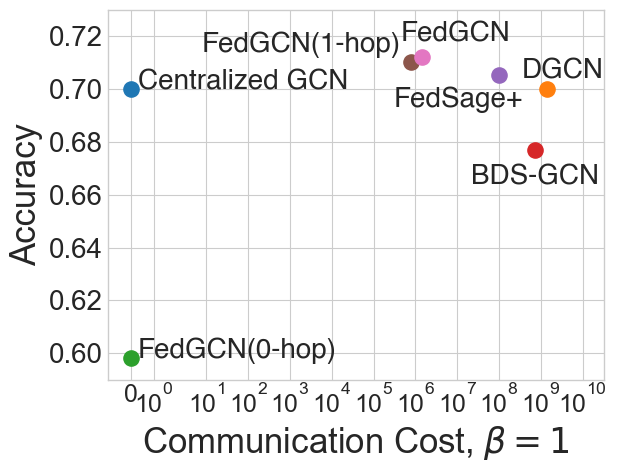

In [175]:
one_hop_count = 777554
two_hop_count = 1464635
BDS_one_local_update = 687081
L = 3
local_steps = 3
bds_sample_rate = 0.5
global_round = 200

iid_total_bds = bds_one * L * global_round * local_steps * bds_sample_rate #times convergence time

iid_total_dgcn = bds_one * L * global_round * local_steps

iid_total_fedsage = len(labels) * global_round * local_steps

plt.style.use('seaborn-whitegrid')
x = [0, iid_total_dgcn, 0, iid_total_bds, iid_total_fedsage, one_hop_count, two_hop_count]

y = [0.7, 0.7, 0.5981, 0.6769,0.7053, 0.7101, 0.712]

n = ["Centralized GCN", "DGCN", "FedGCN(0-hop)", "BDS-GCN", "FedSage+", "FedGCN(1-hop)", "FedGCN"]

fig, ax = plt.subplots()

ax.scatter(x[0], y[0], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[5], y[5], s=120)
ax.scatter(x[6], y[6], s=120)



hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
    
    #change location of model annotation
    if '0-hop' in txt:
        ax.annotate(txt, (x[i] + 0.3, y[i]), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i] * 0.00001, y[i] + 0.004), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i] * 0.3, y[i] + 0.006 ), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] * 0.03, y[i] - 0.013), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i]+0.3, y[i]), fontsize=20, **hfont)
    elif 'FedSage+' in txt:
        ax.annotate(txt, (x[i] * 0.003, y[i] - 0.012), fontsize=20, **hfont)
    elif 'DGCN' in txt:
        ax.annotate(txt, (x[i] * 0.25, y[i] + 0.004), fontsize=20, **hfont)
    
        
        
#ax.set_xscale('log')

ax.set_xscale('symlog')

plt.xlim(-0.99, 10**10.5)


plt.ylim(0.59,0.73)



plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, $\\beta=1$', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')

fig = plt.gcf()
#fig.set_size_inches((8.5, 11), forward=False)

fig.savefig("ogbn-arxiv_comm_accuracy_beta_1.pdf", format='pdf', bbox_inches = "tight")